In [ ]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify
!pip install patchify albumentations[imgaug] scikit-image
# if you will write COCO later:
!pip install pycocotools
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-8scrgit6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-8scrgit6
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import os

base_dir = "/content/drive/MyDrive/Electron_Microscope_Practice_Projects/Mitochondria_segmentation/"

# Define paths for both NPZ files
train_output_filename = os.path.join(base_dir, 'train_data_processed.npz')
val_output_filename   = os.path.join(base_dir, 'val_data_processed.npz')

# Load training data
try:
    with np.load(train_output_filename) as data:
        train_img = data['images']
        train_mask = data['masks']
    print(f"--- Loaded Training Data from {os.path.basename(train_output_filename)} ---")
    print(f"  'train_img' shape: {train_img.shape}, dtype: {train_img.dtype}")
    print(f"  'train_mask' shape: {train_mask.shape}, dtype: {train_mask.dtype}")
except FileNotFoundError:
    print(f"Error: The file {train_output_filename} was not found. Please ensure it exists.")
except Exception as e:
    print(f"An error occurred while loading the training NPZ file: {e}")

print("\n") # Add a newline for better readability

# Load validation data
try:
    with np.load(val_output_filename) as data:
        val_img = data['images']
        val_mask = data['masks']
    print(f"--- Loaded Validation Data from {os.path.basename(val_output_filename)} ---")
    print(f"  'val_img' shape: {val_img.shape}, dtype: {val_img.dtype}")
    print(f"  'val_mask' shape: {val_mask.shape}, dtype: {val_mask.dtype}")
except FileNotFoundError:
    print(f"Error: The file {val_output_filename} was not found. Please ensure it exists.")
except Exception as e:
    print(f"An error occurred while loading the validation NPZ file: {e}")


--- Loaded Training Data from train_data_processed.npz ---
  'train_img' shape: (608, 256, 256), dtype: float32
  'train_mask' shape: (608, 256, 256), dtype: uint8


--- Loaded Validation Data from val_data_processed.npz ---
  'val_img' shape: (33, 256, 256), dtype: float32
  'val_mask' shape: (33, 256, 256), dtype: uint8


In [ ]:
import ipywidgets as widgets
from IPython.display import display

print("ipywidgets and IPython.display imported successfully.")

ipywidgets and IPython.display imported successfully.


## Visualize train dataset

In [ ]:
def plot_train_data(start_index):
    """
    Plots 4 training images and their corresponding masks in a 2x4 grid,
    looping through the dataset if indices exceed bounds.
    """
    plt.figure(figsize=(8, 5))

    for i in range(4):
        # Calculate the current_index, looping back to the start if out of bounds
        current_index = (start_index + i) % len(train_img)

        # Plot training image
        plt.subplot(2, 4, i + 1) # First row for images
        plt.imshow(train_img[current_index], cmap='gray')
        plt.title(f"Image {current_index}")
        plt.axis('off')

        # Plot training mask
        plt.subplot(2, 4, i + 1 + 4) # Second row for masks
        plt.imshow(train_mask[current_index], cmap='gray')
        plt.title(f"Mask {current_index}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("plot_train_data function redefined to display 4 looping images.")

plot_train_data function redefined to display 4 looping images.


In [ ]:
image_slider = widgets.IntSlider(
    min=0,
    max=len(train_img) - 1,
    step=1,
    description='Start Index (Train):'
)

print("Interactive slider for training data updated. Displaying interactive plot.")

# Use interact to connect the slider to the plotting function
widgets.interactive(plot_train_data, start_index=image_slider)

Interactive slider for training data updated. Displaying interactive plot.


interactive(children=(IntSlider(value=0, description='Start Index (Train):', max=607), Output()), _dom_classes…

## Visualize validation dataset

In [ ]:
def plot_val_data(start_index):
    """
    Plots 4 validation images and their corresponding masks in a 2x4 grid,
    looping through the dataset if indices exceed bounds.
    """
    plt.figure(figsize=(8, 5))

    for i in range(4):
        # Calculate the current_index, looping back to the start if out of bounds
        current_index = (start_index + i) % len(val_img)

        # Plot validation image
        plt.subplot(2, 4, i + 1) # First row for images
        plt.imshow(val_img[current_index], cmap='gray')
        plt.title(f"Image {current_index}")
        plt.axis('off')

        # Plot validation mask
        plt.subplot(2, 4, i + 1 + 4) # Second row for masks
        plt.imshow(val_mask[current_index], cmap='gray')
        plt.title(f"Mask {current_index}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("plot_val_data function redefined to display 4 looping images.")

plot_val_data function redefined to display 4 looping images.


In [ ]:
val_image_slider = widgets.IntSlider(
    min=0,
    max=len(val_img) - 1,
    step=1,
    description='Start Index (Validation):'
)

print("Interactive slider for validation data updated. Displaying interactive plot.")

# Use interact to connect the slider to the plotting function
widgets.interactive(plot_val_data, start_index=val_image_slider)

Interactive slider for validation data updated. Displaying interactive plot.


interactive(children=(IntSlider(value=0, description='Start Index (Validation):', max=32), Output()), _dom_cla…

# now lets start creating the SAM datloader

In [ ]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
train_dataset_dict = {
    "image": [Image.fromarray(img) for img in train_img],
    "label": [Image.fromarray(mask) for mask in train_mask],
}

# Create the dataset using the datasets.Dataset class
train_dataset = Dataset.from_dict(train_dataset_dict)

# for val images

# Convert the NumPy arrays to Pillow images and store them in a dictionary
val_dataset_dict = {
    "image": [Image.fromarray(img) for img in val_img],
    "label": [Image.fromarray(mask) for mask in val_mask],
}

# Create the dataset using the datasets.Dataset class
val_dataset = Dataset.from_dict(val_dataset_dict)

In [ ]:
val_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 33
})

In [ ]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 608
})

## cheking the training dataset

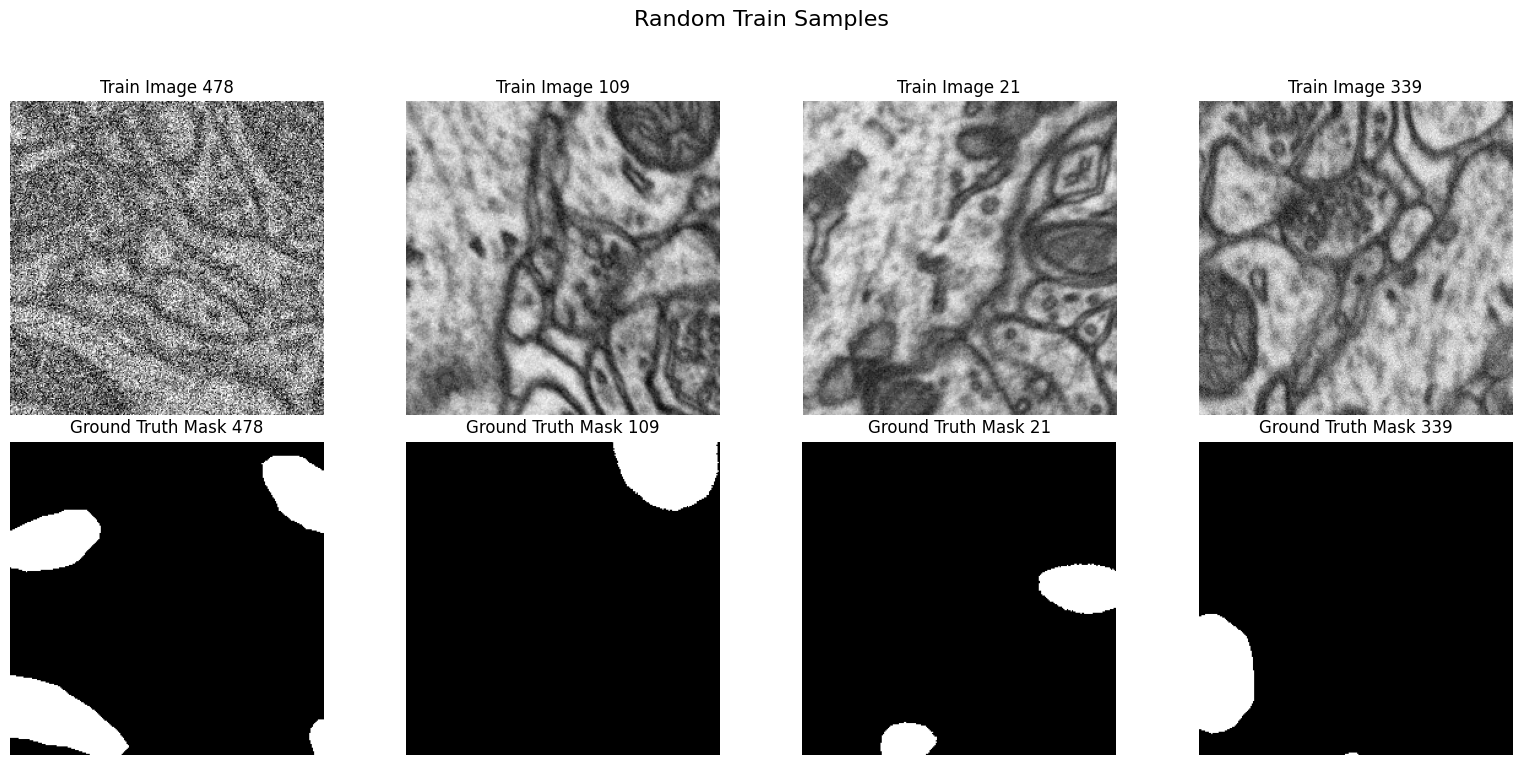

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

n_show = 4

# Pick 4 random Python int indices
idxs = random.sample(range(len(train_dataset)), n_show)

fig, axes = plt.subplots(2, n_show, figsize=(4 * n_show, 8))

for col, idx in enumerate(idxs):
    sample = train_dataset[idx]          # idx is a plain int
    img = np.array(sample['image'])
    msk = np.array(sample['label'])

    # Top row: images
    axes[0, col].imshow(img, cmap='gray')
    axes[0, col].set_title(f'Train Image {idx}')
    axes[0, col].axis('off')

    # Bottom row: masks
    axes[1, col].imshow(msk, cmap='gray')
    axes[1, col].set_title(f'Ground Truth Mask {idx}')
    axes[1, col].axis('off')

fig.suptitle('Random Train Samples', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## checking the validation dataset

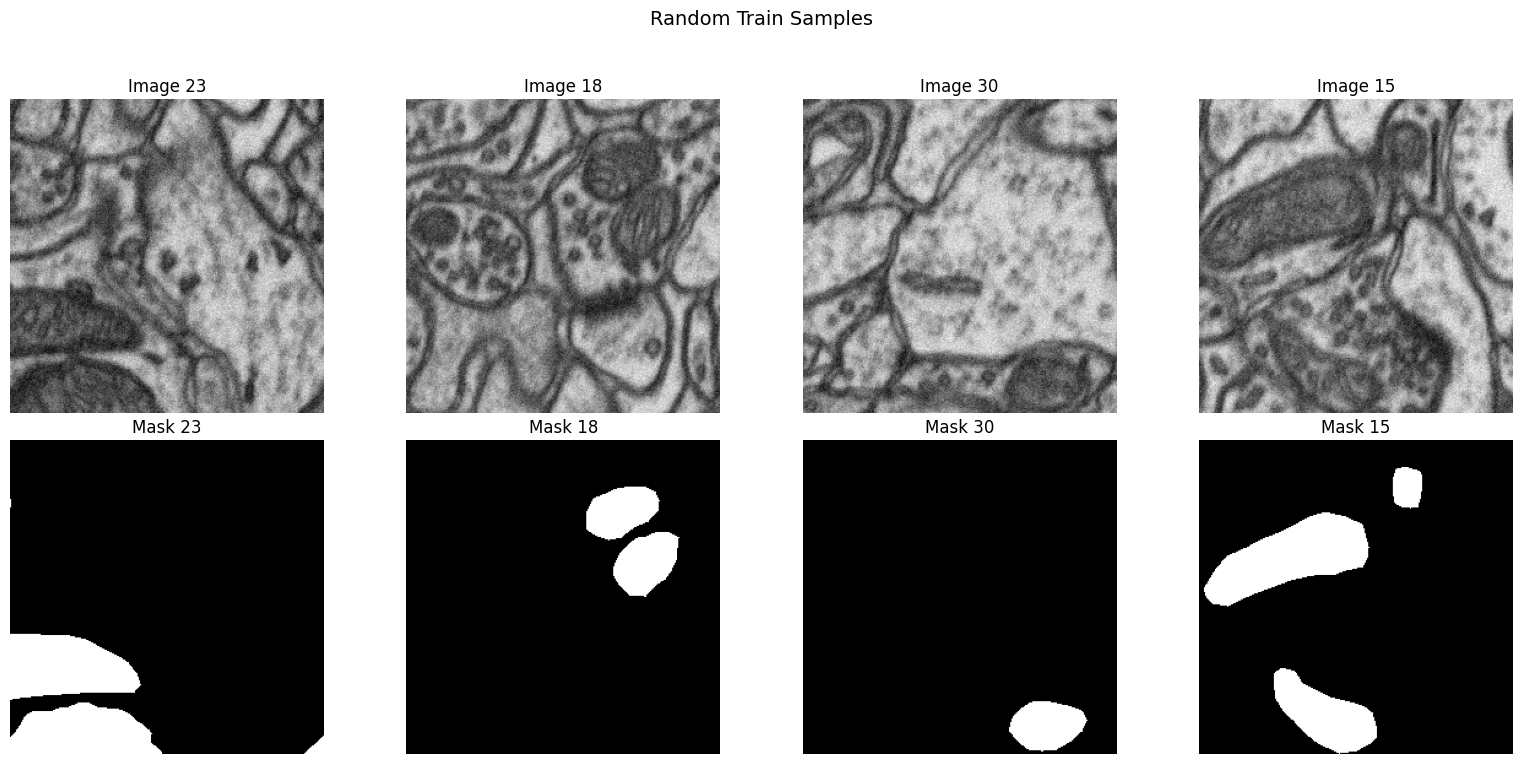

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

n_show = 4

# pick 4 random indices from the dataset
idxs = random.sample(range(len(val_dataset)), n_show)

fig, axes = plt.subplots(2, n_show, figsize=(4 * n_show, 8))

for col, img_num in enumerate(idxs):
    example_image = val_dataset[img_num]["image"]
    example_mask  = val_dataset[img_num]["label"]

    # Top row: images
    axes[0, col].imshow(np.array(example_image), cmap='gray')
    axes[0, col].set_title(f"Image {img_num}")
    axes[0, col].axis('off')

    # Bottom row: masks
    axes[1, col].imshow(np.array(example_mask), cmap='gray')
    axes[1, col].set_title(f"Mask {img_num}")
    axes[1, col].axis('off')

plt.suptitle("Random Train Samples", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## creating promt:
the promts are going to be bounding boxes. so now lets extarct bounding boxes from the segmentions and add them into image

In [ ]:
import numpy as np
from scipy import ndimage

def get_bounding_boxes(mask, perturb=True, max_perturb=20):
    """
    Compute bounding boxes for each connected object in a binary mask.

    Args:
        mask (ndarray): Binary mask (H, W), with nonzero pixels for objects.
        perturb (bool): If True, adds small random perturbation to each bbox.
        max_perturb (int): Maximum random expansion (in pixels).

    Returns:
        boxes (list of [x_min, y_min, x_max, y_max])
    """
    boxes = []
    labeled_mask, num_features = ndimage.label(mask > 0)

    H, W = mask.shape
    for i in range(1, num_features + 1):
        y_indices, x_indices = np.where(labeled_mask == i)
        if len(x_indices) == 0 or len(y_indices) == 0:
            continue

        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        if perturb:
            x_min = max(0, x_min - np.random.randint(0, max_perturb))
            x_max = min(W, x_max + np.random.randint(0, max_perturb))
            y_min = max(0, y_min - np.random.randint(0, max_perturb))
            y_max = min(H, y_max + np.random.randint(0, max_perturb))

        boxes.append([x_min, y_min, x_max, y_max])

    return boxes


## break down the mask as

[(image, mask, [boxA, boxB, boxC] )] --> [
    (image, mask, boxA),
    (image, mask, boxB),
    (image, mask, boxC),
    (image, mask, box_union)
]

In [ ]:
def expand_dataset_with_bboxes(images, masks, include_merged=True, perturb=True, max_perturb=20):
    """
    Expands the dataset by duplicating each image for every bounding box in its mask.
    Optionally adds one merged bounding box that covers all objects.

    Args:
        images (list of np.ndarray or PIL.Image): Input images.
        masks (list of np.ndarray or PIL.Image): Corresponding masks.
        include_merged (bool): Whether to add a combined bbox covering all objects.
        perturb (bool): Whether to randomly expand boxes slightly (for data augmentation).
        max_perturb (int): Maximum random expansion for perturbation.

    Returns:
        list of dict: [{"image": img, "mask": mask, "bbox": box}, ...]
    """
    expanded_data = []

    for img, mask in zip(images, masks):
        mask_array = np.array(mask)
        bboxes = get_bounding_boxes(mask_array, perturb=perturb, max_perturb=max_perturb)

        # Add one record per bounding box
        for bbox in bboxes:
            expanded_data.append({"image": img, "mask": mask, "bbox": bbox})

        # Optionally add a merged bounding box covering all
        if include_merged and len(bboxes) > 1:
            all_xmin = min(b[0] for b in bboxes)
            all_ymin = min(b[1] for b in bboxes)
            all_xmax = max(b[2] for b in bboxes)
            all_ymax = max(b[3] for b in bboxes)
            merged_box = [all_xmin, all_ymin, all_xmax, all_ymax]
            expanded_data.append({"image": img, "mask": mask, "bbox": merged_box})

    print(f"✅ Expanded dataset: {len(images)} → {len(expanded_data)} samples (after bbox duplication)")
    return expanded_data


# expend teh dataset now

In [ ]:
expanded_train = expand_dataset_with_bboxes(
    train_dataset_dict["image"], train_dataset_dict["label"],
    include_merged=True
)

expanded_val = expand_dataset_with_bboxes(
    val_dataset_dict["image"], val_dataset_dict["label"],
    include_merged=True
)

✅ Expanded dataset: 608 → 2226 samples (after bbox duplication)
✅ Expanded dataset: 33 → 120 samples (after bbox duplication)


In [ ]:
expanded_train[4]

{'image': <PIL.Image.Image image mode=F size=256x256>,
 'mask': <PIL.Image.Image image mode=L size=256x256>,
 'bbox': [203, 195, 253, 256]}

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np

def visualize_expanded_dataset(expanded_data, n_cols=5, cell_size=2.2):
    """
    Interactive visualization of expanded dataset.
    Shows top row: images; bottom row: masks with bounding boxes.
    Smaller layout for compact display.
    """
    total = len(expanded_data)

    slider = widgets.IntSlider(
        min=0,
        max=max(0, total - 1),
        step=n_cols,
        value=0,
        description="Start index:",
        continuous_update=False,
        style={'description_width': 'initial'}
    )

    output = widgets.Output()

    def show_samples(start_idx):
        with output:
            clear_output(wait=True)
            fig, axes = plt.subplots(2, n_cols, figsize=(cell_size * n_cols, cell_size * 2))
            fig.suptitle(f"Samples {start_idx} → {start_idx + n_cols - 1}", fontsize=10)

            for i in range(n_cols):
                idx = (start_idx + i) % total
                entry = expanded_data[idx]
                img = np.array(entry["image"])
                mask = np.array(entry["mask"])
                bbox = entry["bbox"]

                # --- Top row: image ---
                axes[0, i].imshow(img, cmap="gray")
                axes[0, i].set_title(f"Image #{idx}", fontsize=8)
                axes[0, i].axis("off")

                # --- Bottom row: mask + box ---
                axes[1, i].imshow(mask, cmap="gray")
                if bbox is not None:
                    x_min, y_min, x_max, y_max = bbox
                    rect = patches.Rectangle(
                        (x_min, y_min),
                        x_max - x_min,
                        y_max - y_min,
                        linewidth=1.5,
                        edgecolor='red',
                        facecolor='none'
                    )
                    axes[1, i].add_patch(rect)
                axes[1, i].set_title(f"{bbox}", fontsize=7)
                axes[1, i].axis("off")

            plt.tight_layout(pad=1.0)
            plt.show()

    slider.observe(lambda change: show_samples(change["new"]), names="value")
    display(slider, output)
    show_samples(slider.value)


## visualize the expended training data

In [ ]:
visualize_expanded_dataset(expanded_train, n_cols=8, cell_size=2.2)


## visualize the extended validation data

In [ ]:
visualize_expanded_dataset(expanded_val, n_cols=8, cell_size=2.2)

IntSlider(value=0, continuous_update=False, description='Start index:', max=119, step=8, style=SliderStyle(des…

Output()

## lets start with defining the model

In [ ]:
# put these imports in the SAME cell as the class, or above it
import numpy as np
import torch
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    def __init__(self, expanded_data, processor):
        self.samples = expanded_data
        self.processor = processor

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        entry = self.samples[idx]
        image = entry["image"]            # PIL.Image
        mask  = np.array(entry["mask"])   # H×W
        box   = entry["bbox"]             # [x_min, y_min, x_max, y_max] in ORIGINAL coords

        enc = self.processor(image, input_boxes=[[box]], return_tensors="pt")
        enc = {k: v.squeeze(0) for k, v in enc.items()}

        enc["ground_truth_mask"] = torch.from_numpy(mask).float()  # H×W
        return enc


In [ ]:
from transformers import SamProcessor
from torch.utils.data import DataLoader

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
train_dataset = SAMDataset(expanded_train, processor)
val_dataset   = SAMDataset(expanded_val, processor)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=False)
val_dataloader   = DataLoader(val_dataset,   batch_size=4, shuffle=False, drop_last=False)


In [ ]:
enc0 = train_dataset[0]
print("pixel_values:", tuple(enc0["pixel_values"].shape))           # (3, 1024, 1024) typically
print("input_boxes:", tuple(enc0["input_boxes"].shape))             # (1, 4)
print("original_sizes:", enc0["original_sizes"].tolist())           # [H_orig, W_orig] ~ [256, 256]
print("reshaped_input_sizes:", enc0["reshaped_input_sizes"].tolist())  # [H_resized, W_resized] ~ [1024, 1024]
print("gt mask:", tuple(enc0["ground_truth_mask"].shape))           # (H_orig, W_orig) ~ (256, 256)


pixel_values: (3, 1024, 1024)
input_boxes: (1, 4)
original_sizes: [256, 256]
reshaped_input_sizes: [1024, 1024]
gt mask: (256, 256)


## visually debug sam sample


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
from PIL import Image

def visualize_sam_sample(dataset, idx=0):
    """
    Visualize one processed sample from SAMDataset.
    Shows: (1) SAM-processed image, (2) mask, (3) overlay with bounding box.
    """
    # --- Get one sample ---
    sample = dataset[idx]
    pixel_values = sample["pixel_values"]          # Tensor or array
    mask = sample["ground_truth_mask"]             # Tensor or array
    bbox = sample["input_boxes"]                   # Tensor/array/list

    # --- Convert pixel_values to numpy image ---
    if isinstance(pixel_values, torch.Tensor):
        img = pixel_values.clone().detach()
        # (C, H, W) -> (H, W, C)
        if img.ndim == 3 and img.shape[0] in (1, 3):
            img = img.permute(1, 2, 0)
        img = img.cpu().numpy()
    else:
        img = np.array(pixel_values)

    # normalize to [0,1]
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    # If grayscale (H, W) make it 3-channel for overlay consistency
    if img.ndim == 2:
        img_rgb = np.stack([img] * 3, axis=-1)
    elif img.ndim == 3 and img.shape[2] == 1:
        img_rgb = np.repeat(img, 3, axis=-1)
    else:
        img_rgb = img

    # --- Convert mask to numpy 2D ---
    if isinstance(mask, torch.Tensor):
        mask = mask.detach().cpu().numpy()
    else:
        mask = np.array(mask)

    # squeeze possible channel / batch dims (e.g. (1,H,W) or (H,W,1))
    if mask.ndim > 2:
        mask = np.squeeze(mask)

    # Ensure mask is uint8 for PIL
    mask_uint8 = mask.astype(np.uint8)

    # --- Resize mask to match SAM image size ---
    H, W = img_rgb.shape[:2]
    if mask_uint8.shape != (H, W):
        mask_resized = np.array(
            Image.fromarray(mask_uint8).resize((W, H), Image.NEAREST)
        )
    else:
        mask_resized = mask_uint8

    # --- Create overlay: red where mask > 0 ---
    overlay = img_rgb.copy()
    overlay[mask_resized > 0] = [1.0, 0.0, 0.0]

    # --- Convert bbox to numpy (4,) ---
    if isinstance(bbox, torch.Tensor):
        bbox_np = bbox.squeeze(0).detach().cpu().numpy()  # assume (1,4)
    else:
        bbox_np = np.array(bbox).squeeze()

    x_min, y_min, x_max, y_max = bbox_np

    # --- Plot ---
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    titles = ["SAM Input Image", "Ground Truth Mask", "Overlay (Mask + Box)"]

    # 1️⃣ SAM input image
    # if original is grayscale, show the first channel
    axes[0].imshow(img if img.ndim == 2 else img_rgb, cmap="gray" if img.ndim == 2 else None)
    axes[0].set_title(titles[0])
    axes[0].axis("off")

    # 2️⃣ Ground truth mask
    axes[1].imshow(mask_resized, cmap="gray")
    axes[1].set_title(titles[1])
    axes[1].axis("off")

    # 3️⃣ Overlay with bounding box
    axes[2].imshow(overlay)
    rect = patches.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        linewidth=2,
        edgecolor="yellow",
        facecolor="none",
    )
    axes[2].add_patch(rect)
    axes[2].set_title(titles[2])
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    # Print details for inspection
    print(f"Sample #{idx}")
    print(f"  pixel_values shape: {sample['pixel_values'].shape}")
    print(f"  input_boxes: {bbox_np}")
    print(f"  mask shape: {mask_resized.shape}, unique values: {np.unique(mask_resized)}")


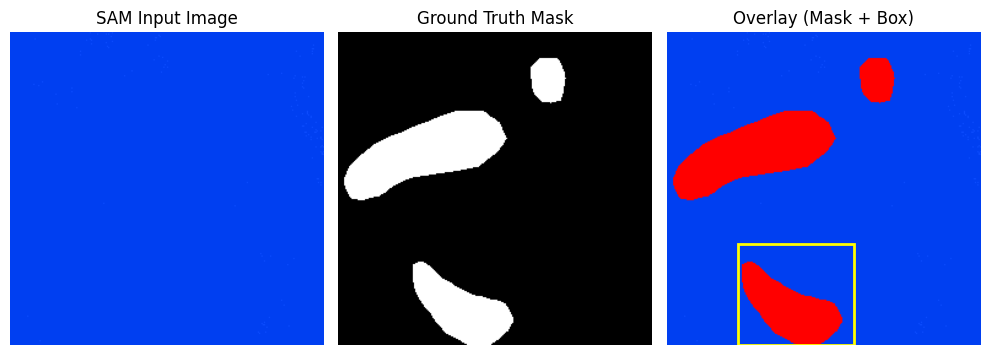

Sample #263
  pixel_values shape: torch.Size([3, 1024, 1024])
  input_boxes: [ 232.  692.  612. 1024.]
  mask shape: (1024, 1024), unique values: [  0 255]


In [ ]:
import random
idx = random.randint(0, len(train_dataset) - 1)
visualize_sam_sample(train_dataset, idx)


In [ ]:
import torch
from transformers import SamModel
from monai.losses import DiceFocalLoss

model = SamModel.from_pretrained("facebook/sam-vit-base")

# Freeze encoder and prompt encoder (train only mask decoder)
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

optimizer = torch.optim.Adam(model.mask_decoder.parameters(), lr=1e-5)
seg_loss = DiceFocalLoss(sigmoid=True, lambda_dice=1.0, lambda_focal=1.0, reduction='mean')

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionSdpaAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm((25

In [ ]:
from tqdm import tqdm
from statistics import mean

num_epochs = 5
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # ------------------- TRAIN -------------------
    model.train()
    epoch_train_losses = []

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            input_boxes=batch["input_boxes"].to(device),
            multimask_output=False
        )

        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)

        # Resize ground truth mask to match predicted mask size (256×256)
        if ground_truth_masks.shape[-1] != predicted_masks.shape[-1]:
            ground_truth_masks = torch.nn.functional.interpolate(
                ground_truth_masks.unsqueeze(1),
                size=predicted_masks.shape[-2:],
                mode="nearest"
            ).squeeze(1)

        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())

    mean_train_loss = mean(epoch_train_losses)
    train_losses.append(mean_train_loss)

    # ------------------- VALIDATION -------------------
    model.eval()
    epoch_val_losses = []
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                input_boxes=batch["input_boxes"].to(device),
                multimask_output=False
            )

            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)

            # Match spatial dimensions
            if ground_truth_masks.shape[-1] != predicted_masks.shape[-1]:
                ground_truth_masks = torch.nn.functional.interpolate(
                    ground_truth_masks.unsqueeze(1),
                    size=predicted_masks.shape[-2:],
                    mode="nearest"
                ).squeeze(1)

            val_loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            epoch_val_losses.append(val_loss.item())

    mean_val_loss = mean(epoch_val_losses)
    val_losses.append(mean_val_loss)

    # 🔥 Print progress
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {mean_train_loss:.4f} | Val Loss: {mean_val_loss:.4f}")

# ------------------- SAVE MODEL -------------------
torch.save(model.state_dict(), "/content/drive/MyDrive/Electron_Microscope_Practice_Projects/Mitochondria_segmentation/demo_model_checkpoint.pth")

# ------------------- PLOT LOSSES -------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (DiceFocal)')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/5 [Train]:   0%|          | 1/557 [00:05<47:17,  5.10s/it]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (DiceFocal)')
plt.legend()
plt.grid(True)
plt.show()

## Inference Step

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/Electron_Microscope_Practice_Projects/Mitochondria_segmentation/demo_model_checkpoint.pth"))

<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionSdpaAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm((25

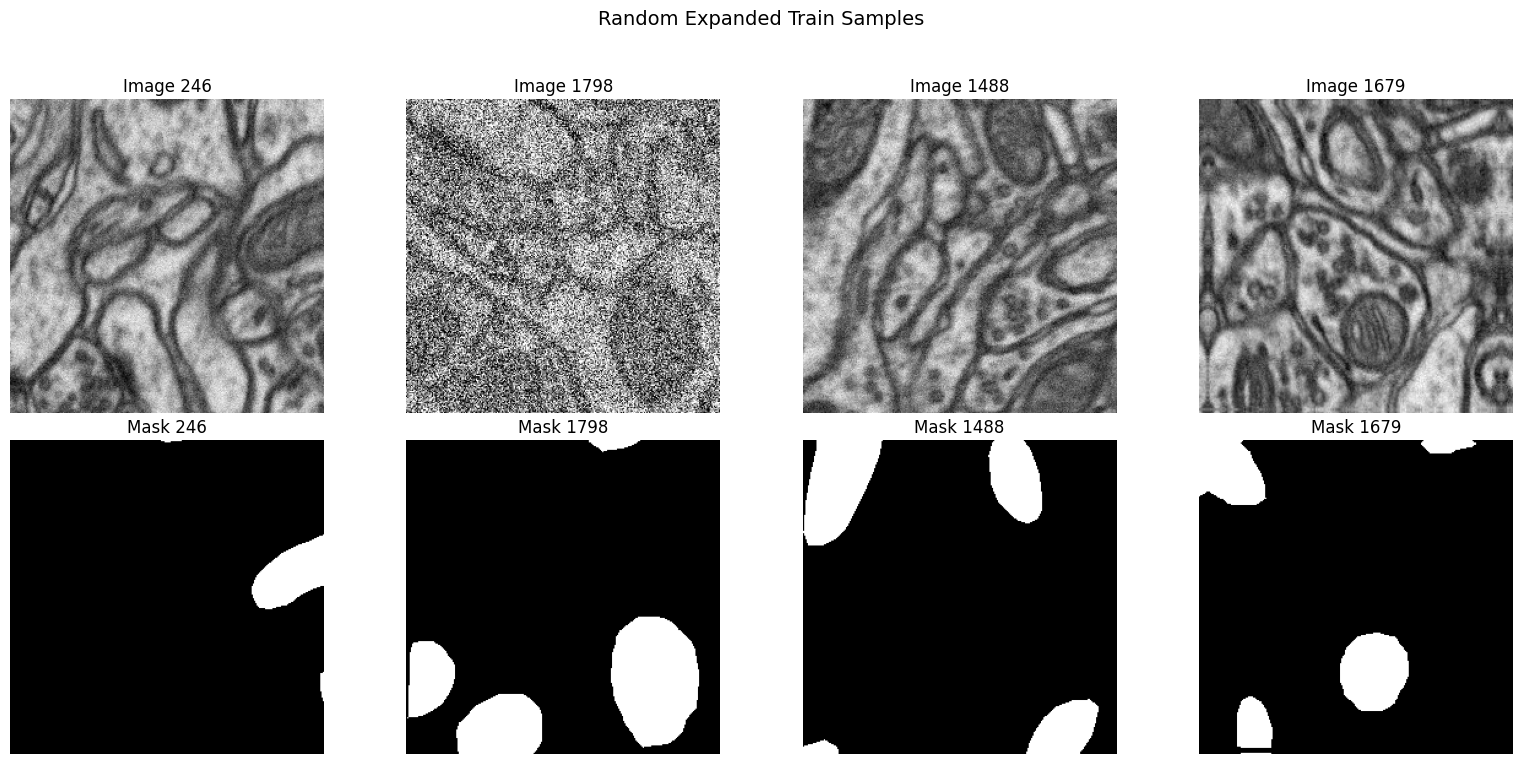

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

n_show = 4  # how many random samples to display

idxs = random.sample(range(len(expanded_train)), n_show)

fig, axes = plt.subplots(2, n_show, figsize=(4 * n_show, 8))

for col, idx in enumerate(idxs):
    sample = expanded_train[idx]

    image_to_visualize = np.array(sample['image'])
    mask_to_visualize  = np.array(sample['mask'])

    # Top row: images
    axes[0, col].imshow(image_to_visualize, cmap='gray')
    axes[0, col].set_title(f'Image {idx}')
    axes[0, col].axis('off')

    # Bottom row: masks
    axes[1, col].imshow(mask_to_visualize, cmap='gray')
    axes[1, col].set_title(f'Mask {idx}')
    axes[1, col].axis('off')

plt.suptitle('Random Expanded Train Samples', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
print("Original image size:", expanded_train[idx]["image"].size)
print("Prompt box (original):", expanded_train[idx]["bbox"])
print("Input box (after processor):", train_dataset[idx]["input_boxes"])


Original image size: (256, 256)
Prompt box (original): [24, 202, 70, 256]
Input box (after processor): tensor([[  96.,  808.,  280., 1024.]], dtype=torch.float64)


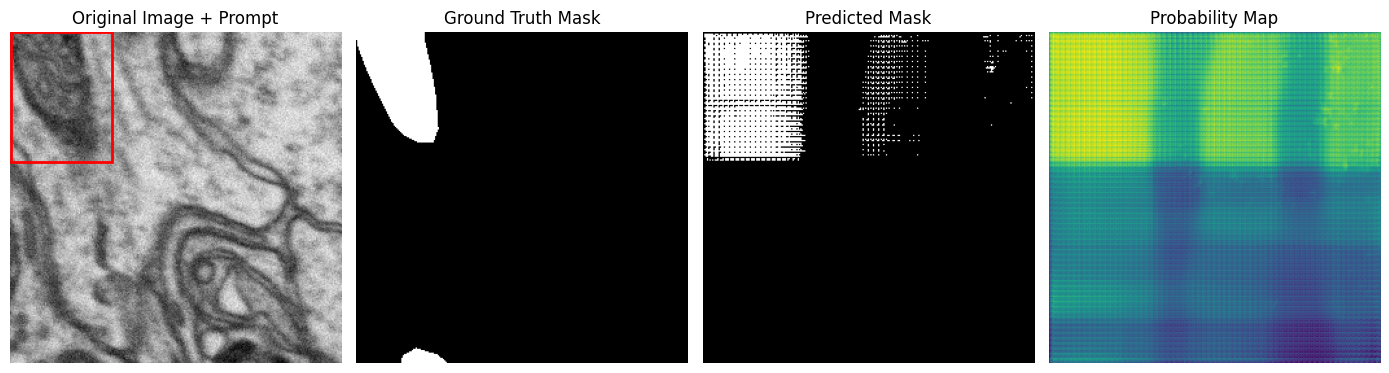

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# pick a random training example
idx = random.randint(0, len(expanded_train) - 1)

# --- Load image + mask ---
sample_expanded = expanded_train[idx]
test_image_display = np.array(sample_expanded["image"])
ground_truth_mask = np.array(sample_expanded["mask"])
prompt_box = sample_expanded["bbox"]

# --- Load processed SAM tensors ---
sample_proc = train_dataset[idx]
inputs_to_model = {
    "pixel_values": sample_proc["pixel_values"].unsqueeze(0).to(device),
    "input_boxes": sample_proc["input_boxes"].unsqueeze(0).to(device),
    "original_sizes": sample_proc["original_sizes"].unsqueeze(0).to(device),
    "reshaped_input_sizes": sample_proc["reshaped_input_sizes"].unsqueeze(0).to(device)
}

# --- Model inference ---
my_mito_model.eval()
with torch.no_grad():
    outputs = my_mito_model(**inputs_to_model, multimask_output=False)

# --- Postprocess masks ---
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.7).astype(np.uint8)

# --- Plot ---
fig, axes = plt.subplots(1, 4, figsize=(14, 4))

# (1) Original image + bounding box prompt
axes[0].imshow(test_image_display, cmap="gray")
x_min, y_min, x_max, y_max = prompt_box
rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                         linewidth=2, edgecolor='red', facecolor='none')
axes[0].add_patch(rect)
axes[0].set_title("Original Image + Prompt")
axes[0].axis("off")

# (2) Ground truth mask
axes[1].imshow(ground_truth_mask, cmap="gray")
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

# (3) Predicted mask
axes[2].imshow(medsam_seg, cmap="gray")
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

# (4) Probability heatmap
axes[3].imshow(medsam_seg_prob, cmap="viridis")
axes[3].set_title("Probability Map")
axes[3].axis("off")

plt.tight_layout()
plt.show()
